In [ ]:
import tensorflow
import cv2
import numpy as np
import matplotlib.pyplot as plt
import keras.layers as layers
from keras.models import Model
from keras.preprocessing import image

from tensorflow.keras.regularizers import l2

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import cv2
from google.colab.patches import cv2_imshow


from keras import backend as K
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from sklearn.utils import shuffle

In [ ]:
from keras.initializers import glorot_uniform


def identity_block(input_tensor, kernel_size, filters, stage, block):
    """ 
    An identity block.

    Parameters
    ----------
    input_tensor:

    kernel_size: int
        The kernel size of middle conv layer at main path.

    filters: list[int]
        The filters of 3 conv layer at main path.

    stage: int
        Current stage label, used for generating layer names.

    block: : str
        'a','b'..., current block label, used for generating layer names.

    Returns
    -------
    Output tensor for the block.
    """
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # for batch normalization layer, we assume
    # the input data is in channel last format
    bn_axis = 3

    filters1, filters2, filters3 = filters
  
    # main path, note that setting the kernel_initializer seed here is only used
    # for reproducibility, we techniqually don't need it
    x = layers.Conv2D(filters1, kernel_size=(1, 1), strides=(1, 1),
                      kernel_initializer=glorot_uniform(seed=0),
                      padding='valid', name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, strides=(1, 1),
                      kernel_initializer=glorot_uniform(seed=0),
                      padding='same', name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, kernel_size=(1, 1), strides=(1, 1),
                      kernel_initializer=glorot_uniform(seed=0),
                      padding='valid', name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    # this line is the core component of resnet, the skip connection, i.e.
    # having a shortcut to the main path before the activation, when addition
    # is performed on convolutional layers, the element-wise addition is performed
    # on their feature maps, i.e. channel by channel
    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x

In [ ]:
def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    """ 
    A block that has a conv layer at shortcut.

    Parameters
    ----------
    input_tensor:
    
    kernel_size: int
        The kernel size of middle conv layer at main path.

    filters: list[int]
        The filters of 3 conv layer at main path.

    stage: int
        Current stage label, used for generating layer names.

    block: : str
        'a','b'..., current block label, used for generating layer names.
        
    strides : tuple, default (2, 2)
        Strides for the first conv layer in the block.

    Returns
    -------
    Output tensor for the block.
    """
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # for batch normalization layer, we assume
    # the input data is in channel last format,
    # which is the case if we are using the default
    # keras' backend tensorflow
    bn_axis = 3

    filters1, filters2, filters3 = filters
  
    # main path, note that setting the kernel_initializer set here is only used
    # for reproducibility, we techniqually don't need it
    x = layers.Conv2D(filters1, kernel_size=(1, 1), strides=strides,
                      kernel_initializer=glorot_uniform(seed=0),
                      padding='valid', name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, strides=(1, 1),
                      kernel_initializer=glorot_uniform(seed=0),
                      padding='same', name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, kernel_size=(1, 1), strides=(1, 1),
                      kernel_initializer=glorot_uniform(seed=0),
                      padding='valid', name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)
    
    # we resize the input so its dimension will match the output dimension
    # of the main path
    shortcut = layers.Conv2D(filters3, kernel_size=(1, 1), strides=strides,
                             kernel_initializer=glorot_uniform(seed=0),
                             padding='valid', name=conv_name_base + '1')(input_tensor)
    shortcut = layers.BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut) 

    # this line is the core component of resnet, the skip connection, i.e.
    # having a shortcut to the main path before the activation
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

In [ ]:
from keras.datasets import cifar10
from keras.utils import np_utils


(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print(x_train.shape, 'train samples')
print(x_test.shape, 'test samples')
print(y_train.shape, 'train labels')
print(y_test.shape, 'test labels')

170508288/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3) train samples
(10000, 32, 32, 3) test samples
(50000, 1) train labels
(10000, 1) test labels


In [ ]:
print(y_train[2].shape)


(1,)


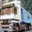

[[[ 59  62  63]
  [ 43  46  45]
  [ 50  48  43]
  ...
  [158 132 108]
  [152 125 102]
  [148 124 103]]

 [[ 16  20  20]
  [  0   0   0]
  [ 18   8   0]
  ...
  [123  88  55]
  [119  83  50]
  [122  87  57]]

 [[ 25  24  21]
  [ 16   7   0]
  [ 49  27   8]
  ...
  [118  84  50]
  [120  84  50]
  [109  73  42]]

 ...

 [[208 170  96]
  [201 153  34]
  [198 161  26]
  ...
  [160 133  70]
  [ 56  31   7]
  [ 53  34  20]]

 [[180 139  96]
  [173 123  42]
  [186 144  30]
  ...
  [184 148  94]
  [ 97  62  34]
  [ 83  53  34]]

 [[177 144 116]
  [168 129  94]
  [179 142  87]
  ...
  [216 184 140]
  [151 118  84]
  [123  92  72]]]


In [ ]:
cv2_imshow(x_train[1])
print(x_train[0])

In [ ]:
n_classes = 10
img_rows, img_cols, img_channel = 32, 32, 3

# mnist is grey-scaled image, thus the last dimension, channel size will be 1
X_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, img_channel)
X_test  = x_test.reshape(x_test.shape[0], img_rows, img_cols, img_channel)
input_shape = img_rows, img_cols, img_channel

X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')

# images takes values between 0 - 255, we can normalize it
# by dividing every number by 255
X_train /= 255
X_test /= 255
print('train shape:', X_train.shape)

# one-hot encode the class (target) vectors
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test , n_classes)
print('Y_test shape:', Y_test.shape)
Y_test[0].shape

train shape: (50000, 32, 32, 3)
Y_test shape: (10000, 10)


(10,)

In [ ]:
Y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
def ResNet(input_shape, n_classes):
    """
    Definition of ResNet
    
    References
    ----------
    https://github.com/keras-team/keras-applications/blob/master/keras_applications/resnet50.py
    """
    img_input = layers.Input(shape=input_shape)
    
    bn_axis = 3
    
    x = layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(img_input)
    x = layers.Conv2D(64, (7, 7),
                      strides=(2, 2),
                      padding='valid',
                      kernel_initializer='he_normal',
                      name='conv1')(x)
    x = layers.BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = layers.Activation('relu')(x)
    x = layers.ZeroPadding2D(padding=(1, 1), name='pool1_pad')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')
    
    # the commented out blocks are what's needed to build out the
    # full ResNet50 (a ResNet with 50 layers), we won't be needing
    # the complexity here
    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    #x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    # x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    # x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    # x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    # x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    # x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')
    
    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    #img_output = layers.Dense(n_classes, activation='softmax', name='fc' + str(n_classes))(x)
    img_output = layers.Dense(n_classes, kernel_regularizer=tensorflow.keras.regularizers.l2(0.01),activation ='softmax' , name = 'fc' + str(n_classes))(x); 
    model = Model(inputs=img_input, outputs=img_output, name='resnet')
    return model


model = ResNet(input_shape, n_classes)
model.compile(optimizer = 'adam', loss = 'squared_hinge', metrics = ['accuracy'])
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.summary()

In [ ]:
history = model.fit(X_train[0:1265], Y_train[0:1265], epochs=50, batch_size=32, validation_data=(X_test[0:565], Y_test[0:565]))

Epoch 1/50
40/40 [==============================] - 6s 156ms/step - loss: 0.9626 - accuracy: 0.8474 - val_loss: 1.0117 - val_accuracy: 0.7165
Epoch 2/50
40/40 [==============================] - 6s 142ms/step - loss: 0.9510 - accuracy: 0.8751 - val_loss: 1.0204 - val_accuracy: 0.6932
Epoch 3/50
40/40 [==============================] - 6s 142ms/step - loss: 0.9473 - accuracy: 0.8917 - val_loss: 1.0076 - val_accuracy: 0.7252
Epoch 4/50
40/40 [==============================] - 6s 142ms/step - loss: 0.9430 - accuracy: 0.8980 - val_loss: 1.0092 - val_accuracy: 0.7203
Epoch 5/50
40/40 [==============================] - 6s 141ms/step - loss: 0.9368 - accuracy: 0.9083 - val_loss: 1.0180 - val_accuracy: 0.6984
Epoch 6/50
40/40 [==============================] - 6s 142ms/step - loss: 0.9348 - accuracy: 0.9194 - val_loss: 1.0083 - val_accuracy: 0.7247
Epoch 7/50
40/40 [==============================] - 6s 142ms/step - loss: 0.9318 - accuracy: 0.9265 - val_loss: 1.0057 - val_accuracy: 0.7298
Epoch 

In [ ]:
loss, accuracy = model.evaluate(X_test, Y_test)
print('Loss = ' + str(loss))
print('Test Accuracy = ' + str(accuracy))

313/313 [==============================] - 4s 14ms/step - loss: 1.0206 - accuracy: 0.6888
Loss = 1.020601749420166
Test Accuracy = 0.6887999773025513


In [ ]:
#!pip install -q tensorflow==2.0.0b1
# Install bleeding edge version of cleverhans
!pip install git+https://github.com/tensorflow/cleverhans.git#egg=cleverhans

import cleverhans
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt



  Cloning https://github.com/tensorflow/cleverhans.git to /tmp/pip-install-voyyymfb/cleverhans_0b1277c443ed4136bb320ab41a76a31e
  Running command git clone -q https://github.com/tensorflow/cleverhans.git /tmp/pip-install-voyyymfb/cleverhans_0b1277c443ed4136bb320ab41a76a31e
     |████████████████████████████████| 154 kB 5.4 MB/s 
     |████████████████████████████████| 42 kB 885 kB/s 
  Created wheel for cleverhans: filename=cleverhans-4.0.0-py3-none-any.whl size=92423 sha256=0f2c70ba72516dc16c22d1fb725869cfa00046a7a66781ee5454872bcc04a4fd
  Stored in directory: /tmp/pip-ephem-wheel-cache-_hl8_yjp/wheels/60/54/1e/97e3fe32d62bd252c9fbbee44a0545028c6018b81c054af3e4
Successfully built cleverhans


In [ ]:
# Import the attack
from cleverhans.tf2.attacks import fast_gradient_method

#The attack requires the model to ouput the logits
logits_model = tf.keras.Model(model.input,model.layers[-1].output)
print(logits_model)

In [ ]:
def adv_generate(X_images):
  images = []
  labels = []
  adv_orig_images = []
  adv_orig_labels = []
  epsilon = 0.1

  for item in X_images:
    #cv2_imshow(item)
    adv_orig_images.append(item)
    adv_orig_labels.append(0)

    original_image = tf.convert_to_tensor(item.reshape((1,32,32,3))) 
    adv_img = fast_gradient_method.fast_gradient_method(logits_model, original_image, epsilon, np.inf, targeted=False)
    adv_img = np.reshape(adv_img, (1,32,32,3))

    adv_labels = model.predict(adv_img)
    images.append(np.reshape(adv_img, (32,32,3)))
    #print(adv_labels)
    labels.append(np.reshape(adv_labels,(10)))

    adv_orig_images.append(np.reshape(adv_img,(32,32,3)))
    adv_orig_labels.append(1)

  images = np.array(images)
  labels = np.array(labels)
  adv_orig_images = np.array(adv_orig_images)
  adv_orig_labels = np.array(adv_orig_labels)
  #labels = labels.reshape(-1, 1) 
  adv_orig_labels1 = adv_orig_labels.reshape(-1, 1) 
  adv_orig_images,adv_orig_labels1 = shuffle( adv_orig_images, adv_orig_labels, random_state=23)
  return images, labels, adv_orig_images, adv_orig_labels
  

  

In [ ]:

x_train_adv, y_train_adv, X_train_adv_orig, Y_train_adv_orig = adv_generate(x_train[0:1265])




In [ ]:

x_test_adv, y_test_adv, X_test_adv_orig, Y_test_adv_orig = adv_generate(x_test[0:565])

In [ ]:
X_test_adv_orig[1]

array([[[153., 163., 120.],
        [173., 183., 140.],
        [188., 197., 163.],
        ...,
        [106.,  92.,  68.],
        [ 67.,  54.,  38.],
        [ 61.,  49.,  36.]],

       [[ 69.,  80.,  44.],
        [119., 130.,  95.],
        [182., 192., 159.],
        ...,
        [117.,  93.,  70.],
        [104.,  83.,  67.],
        [110.,  94.,  80.]],

       [[ 50.,  55.,  41.],
        [ 77.,  81.,  68.],
        [174., 180., 162.],
        ...,
        [154., 131., 113.],
        [142., 121., 107.],
        [133., 115.,  98.]],

       ...,

       [[152., 135., 108.],
        [146., 133., 106.],
        [141., 133., 107.],
        ...,
        [152., 144., 127.],
        [162., 152., 132.],
        [126., 112.,  91.]],

       [[147., 130., 113.],
        [132., 121., 106.],
        [125., 114.,  97.],
        ...,
        [174., 163., 139.],
        [177., 168., 147.],
        [140., 131., 109.]],

       [[122., 111.,  92.],
        [109.,  99.,  82.],
        [158., 1

In [ ]:
X_train_adv_orig = X_train_adv_orig.astype('uint8')
#X_train_adv_orig

In [ ]:
X_test_adv_orig = X_test_adv_orig.astype('uint8')
#X_test_adv_orig

In [ ]:
X_train_adv_orig.shape

(4000, 32, 32, 3)

In [ ]:
X_test_adv_orig.shape

(1200, 32, 32, 3)

In [ ]:
Y_test_adv_orig.shape
#X_test_adv_orig.shape

(1200,)

In [ ]:

Y_train_adv_orig

array([0, 1, 0, ..., 1, 0, 1])

In [ ]:
n_classes1 = 2
img_rows1, img_cols1, img_channel1 = 32, 32, 3

# mnist is grey-scaled image, thus the last dimension, channel size will be 1
X_train1_adv_orig = X_train_adv_orig.reshape(X_train_adv_orig.shape[0], img_rows1, img_cols1, img_channel1)
X_test1_adv_orig  = X_test_adv_orig.reshape(X_test_adv_orig.shape[0], img_rows1, img_cols1, img_channel1)
input_shape1 = img_rows1, img_cols1, img_channel1

X_train1_adv_orig = X_train1_adv_orig.astype('float32')
X_test1_adv_orig  = X_test1_adv_orig.astype('float32')

# images takes values between 0 - 255, we can normalize it
# by dividing every number by 255
X_train1_adv_orig /= 255
X_test1_adv_orig /= 255
print('train shape:', X_train1_adv_orig.shape)

# one-hot encode the class (target) vectors
Y_train1_adv_orig = np_utils.to_categorical(Y_train_adv_orig, n_classes1)
Y_test1_adv_orig = np_utils.to_categorical(Y_test_adv_orig , n_classes1)
#print('Y_train shape:', Y_test1_adv_orig.shape)

#Y_train
#Y_train1_adv_orig[0].shape
Y_train1_adv_orig.shape

train shape: (2530, 32, 32, 3)


(2530, 2)

In [ ]:
Y_test_adv_orig.shape

(1130,)

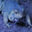

In [ ]:
cv2_imshow(x_test[5])


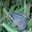

In [ ]:
cv2_imshow(np.reshape(x_test_adv[4], (32,32,3)))

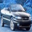

In [ ]:
cv2_imshow(np.reshape(X_train_adv_orig[4], (32,32,3)))

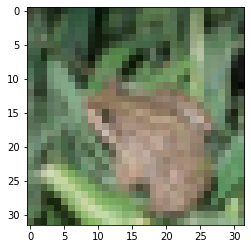

In [ ]:

plt.imshow(np.reshape(x_test_adv[4], (32,32,3)).astype(int))

In [ ]:



Y_train_adv_orig.shape

(4000,)

In [ ]:
cv2_imshow(np.reshape(x_train_adv[4], (32,32,3)))

In [ ]:
x_train_adv.shape

In [ ]:
Y_train_adv_orig

In [ ]:
#X_train_adv_orig.shape[0]
X_train_adv_orig.shape[0]

2530

In [ ]:

def ResNet1(input_shape1, n_classes1):
    """
    Definition of ResNet
    
    References
    ----------
    https://github.com/keras-team/keras-applications/blob/master/keras_applications/resnet50.py
    """
    img_input1 = layers.Input(shape=input_shape1)
    
    bn_axis = 3
    
    x = layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(img_input1)
    x = layers.Conv2D(64, (7, 7),
                      strides=(2, 2),
                      padding='valid',
                      kernel_initializer='he_normal',
                      name='conv1')(x)
    x = layers.BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = layers.Activation('relu')(x)
    x = layers.ZeroPadding2D(padding=(1, 1), name='pool1_pad')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')
    
    # the commented out blocks are what's needed to build out the
    # full ResNet50 (a ResNet with 50 layers), we won't be needing
    # the complexity here
    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    # x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    # x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    # x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    # x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    # x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    # x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')
    
    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    #img_output1 = layers.Dense(n_classes, activation='softmax', name='fc' + str(n_classes))(x)
    #img_output1 = layers.Dense(n_classes1, activation='softmax', name='fc' + str(n_classes1))(x)
             #='linear' , name = 'fc' + str(n_classes))(x); 
    img_output1 = layers.Dense(n_classes1, kernel_regularizer=tensorflow.keras.regularizers.l2(0.01),activation ='softmax' , name = 'fc' + str(n_classes1))(x); 
    #model = Model(inputs=img_input, outputs=img_output, name='resnet')
    model1 = Model(inputs=img_input1, outputs=img_output1, name='resnet1')
    return model1

model1 = ResNet1(input_shape1, n_classes1)
model1.compile(optimizer = 'adam', loss ='binary_crossentropy', metrics = ['accuracy'])
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model1.summary()

In [ ]:
Y_train_adv_orig.shape

(2530,)

In [ ]:
len(Y_train_adv_orig)

In [ ]:
history1 = model1.fit(X_train1_adv_orig, Y_train1_adv_orig, epochs=400, batch_size=32, validation_data=(X_test1_adv_orig, Y_test1_adv_orig))

Epoch 1/400
80/80 [==============================] - 9s 62ms/step - loss: 0.9155 - accuracy: 0.4937 - val_loss: 0.7283 - val_accuracy: 0.5000
Epoch 2/400
80/80 [==============================] - 4s 51ms/step - loss: 0.8190 - accuracy: 0.5138 - val_loss: 0.7728 - val_accuracy: 0.4894
Epoch 3/400
80/80 [==============================] - 4s 51ms/step - loss: 0.7822 - accuracy: 0.5229 - val_loss: 0.7301 - val_accuracy: 0.5000
Epoch 4/400
80/80 [==============================] - 4s 51ms/step - loss: 0.7521 - accuracy: 0.5285 - val_loss: 0.7519 - val_accuracy: 0.4965
Epoch 5/400
80/80 [==============================] - 4s 51ms/step - loss: 0.7418 - accuracy: 0.5482 - val_loss: 0.8054 - val_accuracy: 0.4912
Epoch 6/400
80/80 [==============================] - 4s 51ms/step - loss: 0.7312 - accuracy: 0.5854 - val_loss: 0.9771 - val_accuracy: 0.4947
Epoch 7/400
80/80 [==============================] - 4s 51ms/step - loss: 0.7050 - accuracy: 0.5953 - val_loss: 0.7669 - val_accuracy: 0.4965
Epoch 

In [ ]:
Y_test_adv_orig

array([0, 1, 0, ..., 1, 0, 1])

In [ ]:

loss, accuracy = model1.evaluate(X_test1_adv_orig, Y_test1_adv_orig)
print('Loss = ' + str(loss))
print('Test Accuracy = ' + str(accuracy))

36/36 [==============================] - 1s 19ms/step - loss: 0.9752 - accuracy: 0.4717
Loss = 0.975220799446106
Test Accuracy = 0.4716814160346985
